# Multivariate Example
This notebook outlines an example of scalecast using multiple series to forecast one another. The following concepts are covered:  
1. Exploratory Data Analysis  
2. Univariate modeling with `auto_forecast()`  
3. combination modeling  
4. Plotting test set  
5. Exporting model statistics  
6. Plotting feature importances  
7. Building the `MVForecaster` object from scalecast  
8. Multivariate modeling with `auto_forecast()`  
9. Importing a new sklearn model (`StackingRegressor`) for multivariate combination modeling  

The data is available on Kaggle: https://www.kaggle.com/datasets/neuromusic/avocado-prices

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm as log_progress
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
# read data
data = pd.read_csv('avocado.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])

We will be forecasting the organic and conventional avocado sales from California only.

In [3]:
data_cali = data.loc[data['region'] == 'California']
data_cali_org = data_cali.loc[data_cali['type'] == 'organic']
data_cali_con = data_cali.loc[data_cali['type'] == 'conventional']

## Choose Models and Import Validation Grids

In [4]:
# download template validation grids (will not overwrite existing Grids.py file by default)
models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids(overwrite=False)

## EDA

### Plot

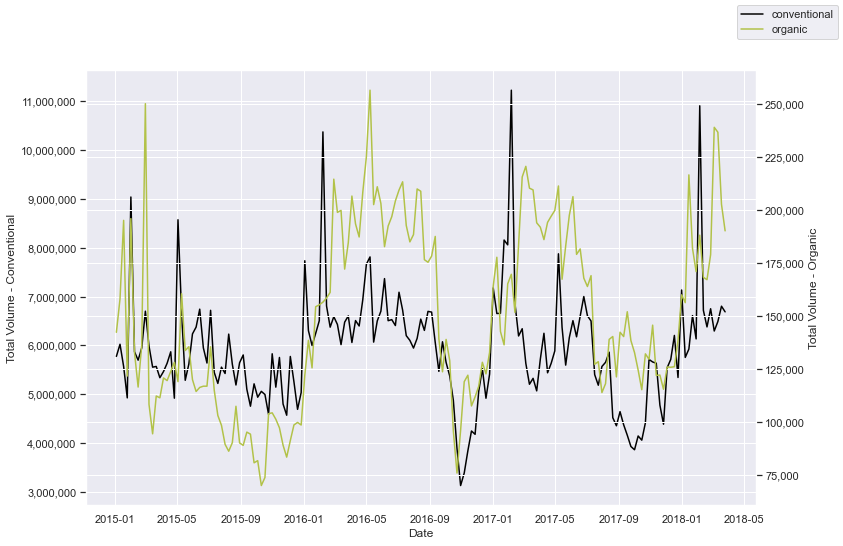

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='Date',y='Total Volume',data=data_cali_con,label='conventional',ax=ax,color='black',legend=False)
plt.ylabel('Total Volume - Conventional')
ax2 = ax.twinx()
sns.lineplot(x='Date',y='Total Volume',data=data_cali_org,label='organic',ax=ax2,color='#B2C248',legend=False)
ax.figure.legend()
plt.ylabel('Total Volume - Organic')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

### Examine Correlation between the series

In [6]:
corr = np.corrcoef(data_cali_org['Total Volume'].values,data_cali_con['Total Volume'].values)[0,1]
print('{:.2%}'.format(corr))

48.02%


### Load into Forecaster from scalecast

In [7]:
fcon = Forecaster(y=data_cali_con['Total Volume'],current_dates = data_cali_con['Date'])
fcon

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [8]:
forg = Forecaster(y=data_cali_org['Total Volume'],current_dates = data_cali_org['Date'])
forg

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

### ACF and PACF Plots

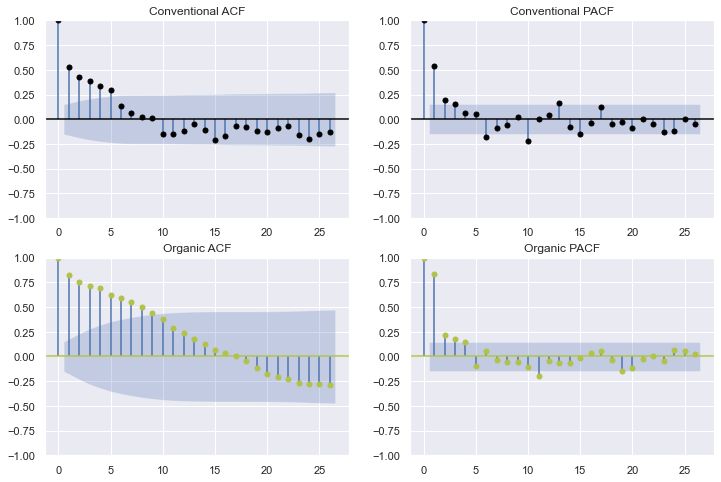

In [9]:
figs, axs = plt.subplots(2, 2)
fcon.plot_acf(ax=axs[0,0],title='Conventional ACF',lags=26,color='black')
fcon.plot_pacf(ax=axs[0,1],title='Conventional PACF',lags=26,color='black')
forg.plot_acf(ax=axs[1,0],title='Organic ACF',lags=26,color='#B2C248')
forg.plot_pacf(ax=axs[1,1],title='Organic PACF',lags=26,color='#B2C248')
plt.show()

### Seasonal Decomposition Plots

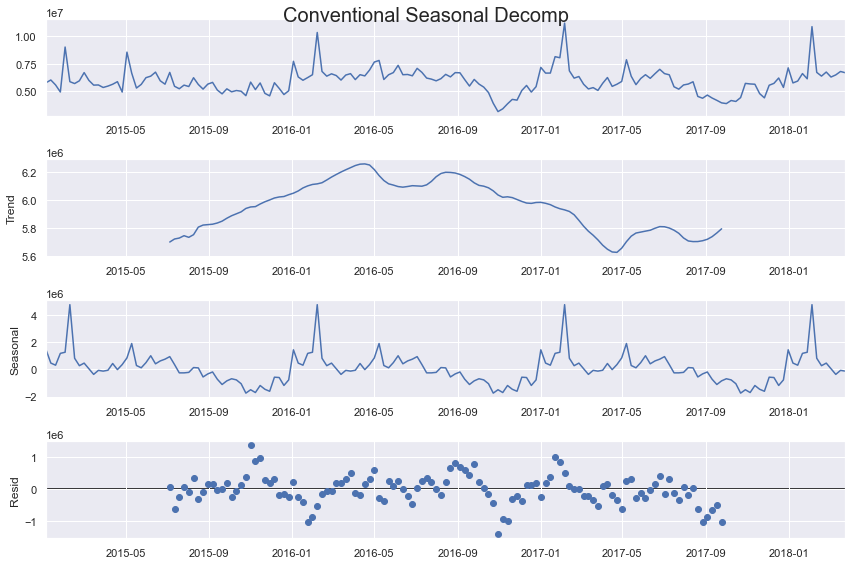

In [10]:
fcon.seasonal_decompose().plot()
plt.suptitle('Conventional Seasonal Decomp',size=20)
plt.show()

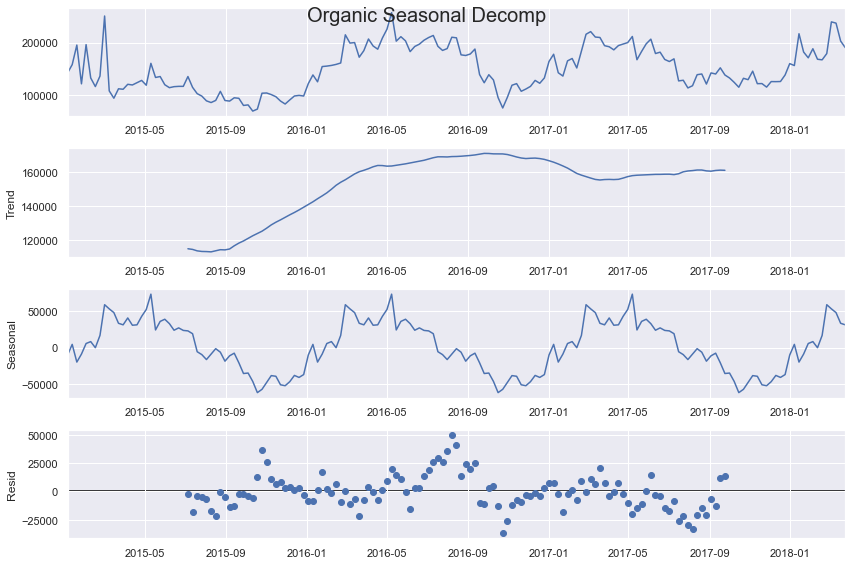

In [11]:
forg.seasonal_decompose().plot()
plt.suptitle('Organic Seasonal Decomp',size=20)
plt.show()

### Check Stationarity

In [12]:
print('-'*100)
print('conventional Augmented Dickey-Fuller results:')
fcon.adf_test(quiet=False,critical_pval=.99)
print('-'*100)
print('organic Augmented Dickey-Fuller results:')
forg.adf_test(quiet=False,critical_pval=.99)
print('-'*100)

----------------------------------------------------------------------------------------------------
conventional Augmented Dickey-Fuller results:
series appears to be stationary
----------------------------------------------------------------------------------------------------
organic Augmented Dickey-Fuller results:
series appears to be stationary
----------------------------------------------------------------------------------------------------


## Scalecast - Univariate

### Load Objects with parameters:
- Forecast horizon (52 weeks)
- Test length (20%)
- Seasonal regressor (week, month, quarter)
- Irregular Cycle (26 weeks)
- Dep Var Lags (13)

In [13]:
for f in (fcon,forg):
    f.generate_future_dates(52)
    f.set_test_length(.2)
    f.add_seasonal_regressors('week','month','quarter',raw=False,sincos=True)
    f.add_seasonal_regressors('year')
    f.add_time_trend()
    f.add_cycle(26)
    f.add_ar_terms(13)

### Tune and Forecast with Selected Models

#### Conventional

In [ ]:
fcon.tune_test_forecast(models,feature_importance=True)
fcon.set_estimator('combo')
fcon.manual_forecast(how='weighted')

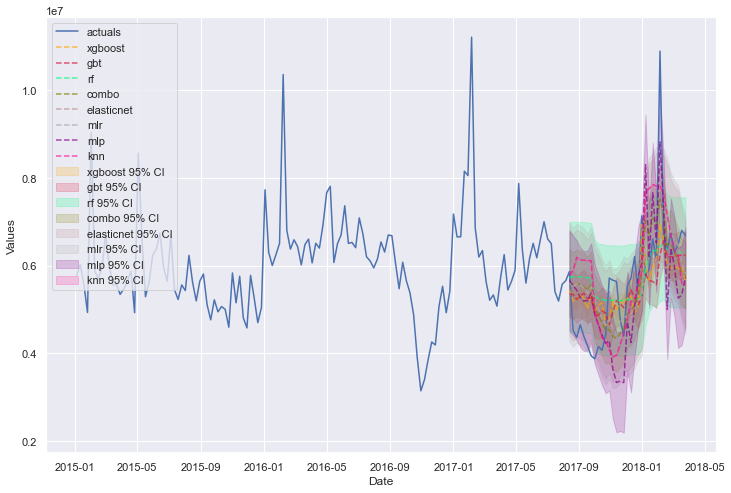

In [14]:
fcon.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
plt.show()

#### Organic

In [ ]:
forg.tune_test_forecast(models,feature_importance=True)
fcon.set_estimator('combo')
fcon.manual_forecast(how='weighted')

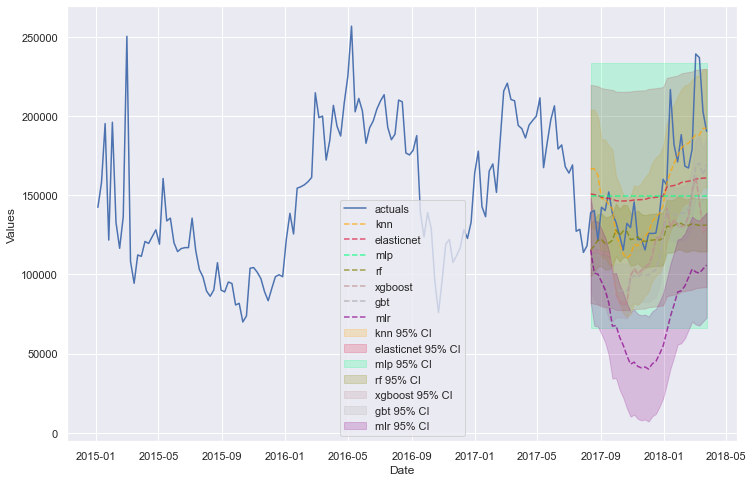

In [15]:
forg.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
plt.show()

### Feature Importance
By default, scalecast uses permutation feature importance from ELI5. After calling a model, the model object from sklearn is available using `f.regr` and that object can be used to export other types of feature importances.

#### Conventional
- Best model: gbt

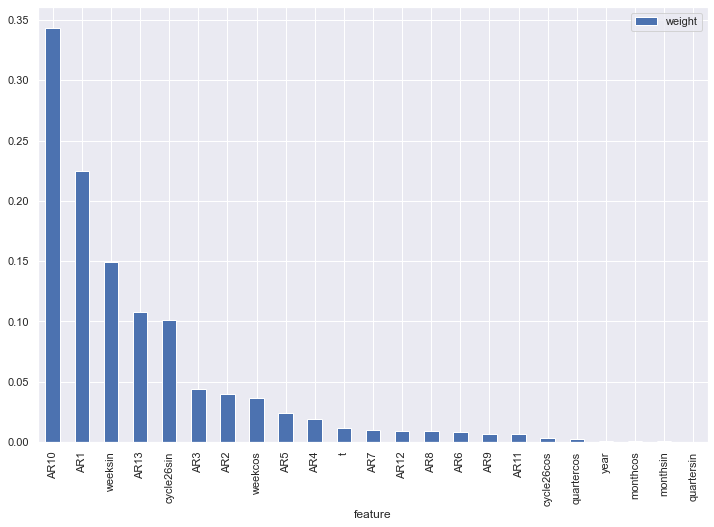

In [16]:
fcon.export_feature_importance('xgboost').plot.bar(y='weight')
plt.show()

#### Organic
- Best model: gbt

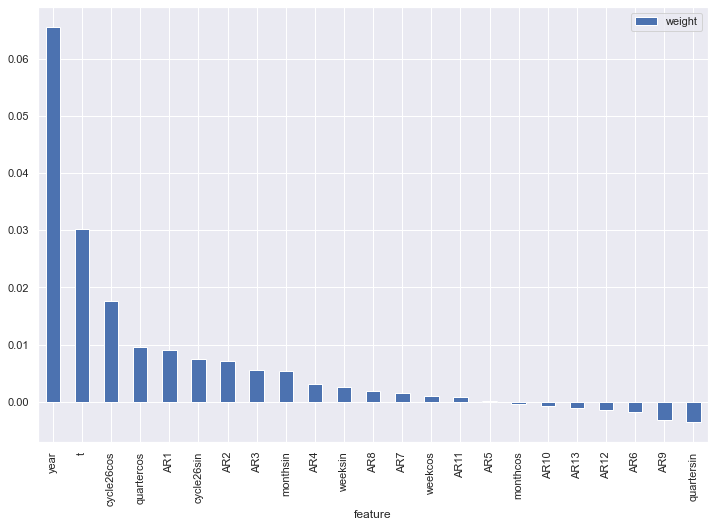

In [17]:
forg.export_feature_importance('knn').plot.bar(y='weight')
plt.show()

### Model Summaries

In [18]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries({'Conventional':fcon,'Organic':forg},determine_best_by='LevelTestSetMAPE')
ms[
    [
        'ModelNickname',
        'Series',
        'Integration',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,Integration,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,best_model
0,xgboost,Conventional,0,0.1317,0.4674,0.0135,0.9919,True
1,gbt,Conventional,0,0.1338,0.3475,0.0382,0.9473,False
2,rf,Conventional,0,0.1510,0.2703,0.0801,0.6918,False
3,combo,Conventional,0,0.1543,0.3861,0.0545,0.8808,False
4,elasticnet,Conventional,0,0.1621,0.3296,0.0959,0.5566,False
5,mlr,Conventional,0,0.1621,0.3296,0.0959,0.5566,False
6,mlp,Conventional,0,0.1871,0.2178,0.0768,0.7712,False
7,knn,Conventional,0,0.2012,0.0383,0.0000,1.0000,False
8,knn,Organic,0,0.0894,0.6231,0.0949,0.8197,True
9,elasticnet,Organic,0,0.1411,0.2423,0.2217,0.3236,False


## Scalecast - Multivariate

### Set MV Parameters
- Forecast horizon already set
- Xvars already set
- Test size must be set: 20%

In [19]:
mvf = MVForecaster(fcon,forg,names=['Conventional','Organic'])
mvf.set_test_length(.2)

### Set Optimize On
- If predicting one series is more important than predicting the other, you can use this code to let the code know to favor one over the other
- By default, it uses the mean error metrics between all series

In [20]:
# how to optimize on one series
mvf.set_optimize_on('Organic')
# how to optimize on the average of both/all series
mvf.set_optimize_on('mean')

### Tune and Test with Selected Models

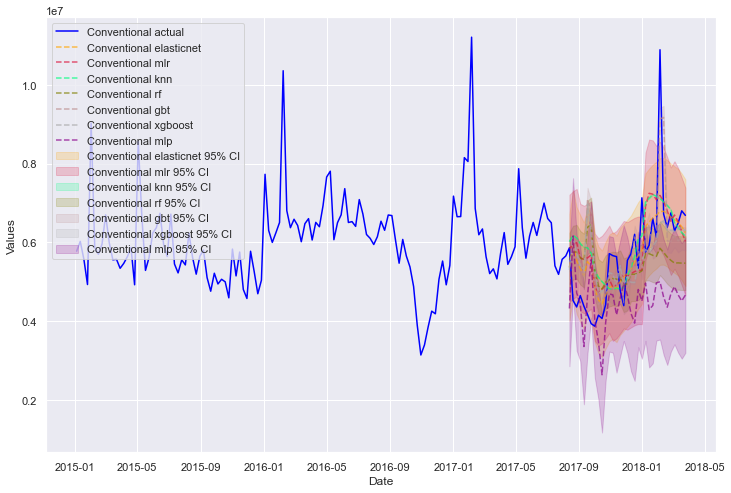

In [21]:
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')

In [ ]:
# not plotting both series at the same time because they have significantly different scales
mvf.plot_test_set(series='Conventional',put_best_on_top=True,ci=True)
plt.show()

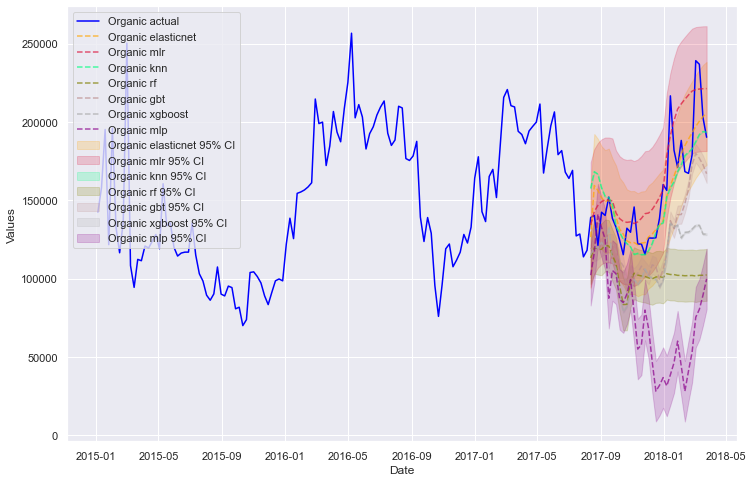

In [22]:
mvf.plot_test_set(series='Organic',put_best_on_top=True,ci=True)
plt.show()

### Export Model Summaries

In [23]:
pd.options.display.max_colwidth = 100
results = mvf.export_model_summaries()
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'Lags'
    ]
]

,ModelNickname,Series,HyperParams,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,Lags
0,elasticnet,Conventional,"{'alpha': 0.1, 'l1_ratio': 0.75}",0.1287,0.4398,0.0901,0.5620,13
1,mlr,Conventional,{},0.1591,0.3282,0.1019,0.4440,1
2,knn,Conventional,"{'n_neighbors': 20, 'weights': 'distance'}",0.1713,0.2682,0.0000,1.0000,13
3,rf,Conventional,"{'max_depth': 5, 'n_estimators': 500}",0.1857,-0.0222,0.0468,0.9089,10
4,gbt,Conventional,"{'max_depth': 3, 'max_features': None}",0.1620,0.3079,0.0195,0.9862,10
5,xgboost,Conventional,{'max_depth': 3},0.1561,0.1860,0.0024,0.9998,13
6,mlp,Conventional,"{'activation': 'relu', 'hidden_layer_sizes': (25,), 'solver': 'lbfgs', 'random_state': 20}",0.2358,-0.7187,0.0815,0.6536,13
7,elasticnet,Organic,"{'alpha': 0.1, 'l1_ratio': 0.75}",0.0803,0.6931,0.0918,0.8393,13
8,mlr,Organic,{},0.1190,0.5739,0.1047,0.7355,1
9,knn,Organic,"{'n_neighbors': 20, 'weights': 'distance'}",0.0905,0.6007,0.0000,1.0000,13


### Import a Foreign Sklearn Estimator for Ensemble Modeling

In [24]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
estimators = [
    ('mlr',LinearRegression(),lags=results.loc[results['ModelNickname'] == 'elasticnet','Lags'].values[0]),
    ('elasticnet',ElasticNet(**results.loc[results['ModelNickname'] == 'elasticnet','HyperParams'].values[0]),lags=results.loc[results['ModelNickname'] == 'elasticnet','Lags'].values[0]),
    ('mlp',MLPRegressor(**results.loc[results['ModelNickname'] == 'mlp','HyperParams'].values[0]),lags=results.loc[results['ModelNickname'] == 'elasticnet','Lags'].values[0])
]

final_estimator = KNeighborsRegressor(**results.loc[results['ModelNickname'] == 'knn','HyperParams'].values[0])

In [29]:
mvf.add_sklearn_estimator(StackingRegressor,'stacking')
mvf.set_estimator('stacking')
mvf.manual_forecast(estimators=estimators,final_estimator=final_estimator,lags=1)

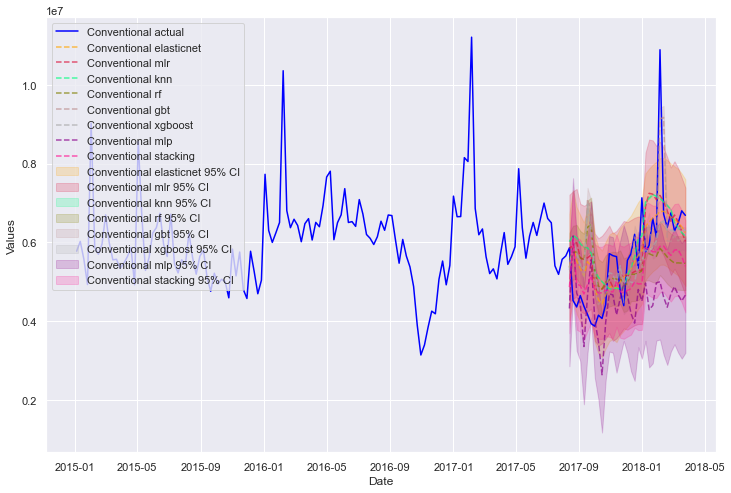

In [30]:
mvf.plot_test_set(series='Conventional',put_best_on_top=True,ci=True)
plt.show()

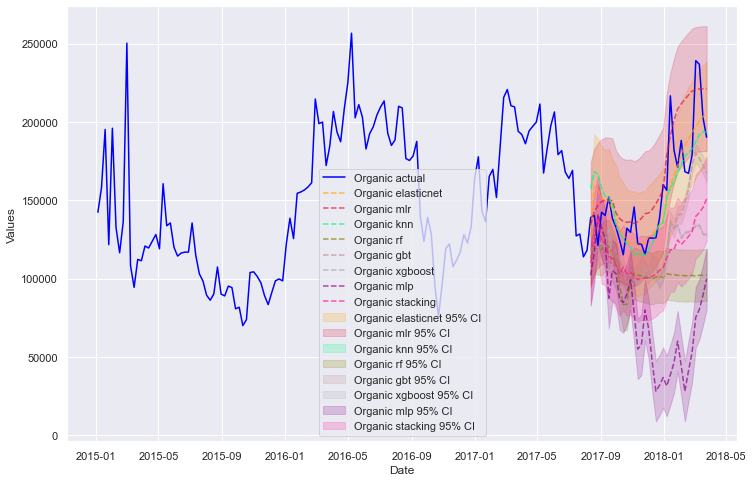

In [31]:
mvf.plot_test_set(series='Organic',put_best_on_top=True,ci=True)
plt.show()

In [32]:
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')
results2 = mvf.export_model_summaries()
results2[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'Lags',
        'best_model'
    ]
]

,ModelNickname,Series,HyperParams,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,Lags,best_model
0,elasticnet,Conventional,"{'alpha': 0.1, 'l1_ratio': 0.75}",0.1287,0.4398,0.0901,0.5620,13,True
1,mlr,Conventional,{},0.1591,0.3282,0.1019,0.4440,1,False
2,knn,Conventional,"{'n_neighbors': 20, 'weights': 'distance'}",0.1713,0.2682,0.0000,1.0000,13,False
3,rf,Conventional,"{'max_depth': 5, 'n_estimators': 500}",0.1857,-0.0222,0.0468,0.9089,10,False
4,gbt,Conventional,"{'max_depth': 3, 'max_features': None}",0.1620,0.3079,0.0195,0.9862,10,False
5,xgboost,Conventional,{'max_depth': 3},0.1561,0.1860,0.0024,0.9998,13,False
6,mlp,Conventional,"{'activation': 'relu', 'hidden_layer_sizes': (25,), 'solver': 'lbfgs', 'random_state': 20}",0.2358,-0.7187,0.0815,0.6536,13,False
7,stacking,Conventional,"{'estimators': [('mlr', LinearRegression()), ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.75)...",0.1478,0.1794,0.0866,0.5453,13,False
8,elasticnet,Organic,"{'alpha': 0.1, 'l1_ratio': 0.75}",0.0803,0.6931,0.0918,0.8393,13,True
9,mlr,Organic,{},0.1190,0.5739,0.1047,0.7355,1,False
